In [1]:
# this script fetches the historical stock data for Amazon (AMZN) using Yahoo Finance API
# and prints the response in JSON format.
# It requires the 'requests' and 'python-dotenv' packages to be installed.
# it also uses an API key stored in a .env file for authentication.
# Make sure to install the required packages using pip:

import requests
import os
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("YF_API_KEY")
url = "https://yahoo-finance15.p.rapidapi.com/api/v1/markets/stock/history"

querystring = {"symbol":"AMZN","interval":"1wk","diffandsplits":"false"}

headers = {
    "x-rapidapi-key": api_key,
    "x-rapidapi-host": "yahoo-finance15.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

AMZN_JSON = response.json()

import json

print(json.dumps(AMZN_JSON, indent=2)[:500])  # Limits output to 500 characters


{
  "meta": {
    "processedTime": "2025-04-09T20:36:22.016601Z",
    "currency": "USD",
    "symbol": "AMZN",
    "exchangeName": "NMS",
    "fullExchangeName": "NasdaqGS",
    "instrumentType": "EQUITY",
    "firstTradeDate": 863703000,
    "regularMarketTime": 1744228802,
    "hasPrePostMarketData": true,
    "gmtoffset": -14400,
    "timezone": "EDT",
    "exchangeTimezoneName": "America/New_York",
    "regularMarketPrice": 191.1,
    "fiftyTwoWeekHigh": 242.52,
    "fiftyTwoWeekLow": 151.61


In [ ]:
#Convert JSON to DataFrame for the main body of the response, this contains the stock data
#The meta data is also available in the response, and is converted to a DataFrame
#The meta data contains information about the stock, such as the symbol, exchange, and currency
#the main body of the response contains the stock data, such as the open, high, low, and close prices
import pandas as pd


JSON_body = AMZN_JSON['body']
AMZN_DF_RAW = pd.json_normalize(JSON_body.values())
Stock_meta_data = pd.json_normalize(AMZN_JSON['meta'])
AMZN_DF_RAW.head()

,date,date_utc,open,high,low,close,volume,adjclose
0,06-04-2020,1586145600,96.80,102.65,96.50,102.14,390220000,102.14
1,13-04-2020,1586750400,102.00,123.05,101.90,118.75,832774000,118.75
2,20-04-2020,1587355200,119.50,122.25,113.98,120.51,527022000,120.51
3,27-04-2020,1587960000,122.16,123.75,112.91,114.30,696276000,114.30
4,04-05-2020,1588564800,112.82,119.36,112.82,118.98,356584000,118.98


In [3]:
#Convert the date column to a datetime object and set it as the index
#We then resample the data to weekly frequency and forward fill any missing values
#We also check for any missing values in the data, as valdation check
AMZN_DF_RAW['date'] = pd.to_datetime(AMZN_DF_RAW['date'], dayfirst=True)
AMZN_DF_RAW.set_index('date', inplace=True)
AMZN_DF_RAW = AMZN_DF_RAW.asfreq('W', method='ffill')
AMZN_DF_RAW.isna().sum()
AMZN_DF_RAW.head()

,date_utc,open,high,low,close,volume,adjclose
date,,,,,,,
2020-04-12,1586145600,96.80,102.65,96.50,102.14,390220000,102.14
2020-04-19,1586750400,102.00,123.05,101.90,118.75,832774000,118.75
2020-04-26,1587355200,119.50,122.25,113.98,120.51,527022000,120.51
2020-05-03,1587960000,122.16,123.75,112.91,114.30,696276000,114.30
2020-05-10,1588564800,112.82,119.36,112.82,118.98,356584000,118.98


In [ ]:
#this take the close price and convert it to a float32 data type
#this is done to save memory and improve performance

AMZN_Close_DF = AMZN_DF_RAW[['close']].astype('float32')
AMZN_Close_DF.head()


,close
date,
2020-04-12,102.139999
2020-04-19,118.750000
2020-04-26,120.510002
2020-05-03,114.300003
2020-05-10,118.980003


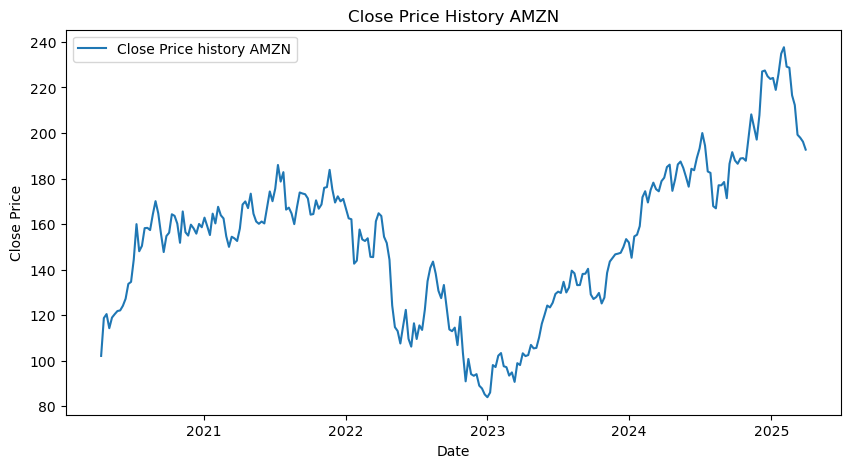

In [ ]:
#This is a simple plot of the close price history for AMZN
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(AMZN_Close_DF['close'].index, AMZN_Close_DF['close'], label='Close Price history AMZN')
plt.title('Close Price History AMZN')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='upper left')
plt.show()

In [ ]:
import numpy as np
from scipy import stats

# z-score
#this checks how many outliers are there in the data set, at 2.0 and 2.5 standard deviations from the mean
#this is a common method for detecting outliers in a data set
z = np.abs(stats.zscore(AMZN_Close_DF['close']))
outliers_2_5 = np.where(z > 2.5)
print(outliers_2_5)
outliers_2 = np.where(z > 2)
print(outliers_2)

(array([251]),)
(array([141, 142, 143, 243, 244, 245, 246, 247, 249, 250, 251, 252, 253]),)


In [ ]:
# IQR
#this is a more robust method of detecting outliers, as it is not affected by the distribution of the data
#we calculate the first and third quartiles, and then calculate the interquartile range (IQR)
Q1 = AMZN_Close_DF['close'].quantile(0.25)
Q3 = AMZN_Close_DF['close'].quantile(0.75)
IQR = Q3 - Q1
outliers = AMZN_DF_RAW[(AMZN_Close_DF['close'] < (Q1 - 1.5 * IQR)) | (AMZN_Close_DF['close'] > (Q3 + 1.5 * IQR))]
print(outliers)

Empty DataFrame
Columns: [date_utc, open, high, low, close, volume, adjclose]
Index: []


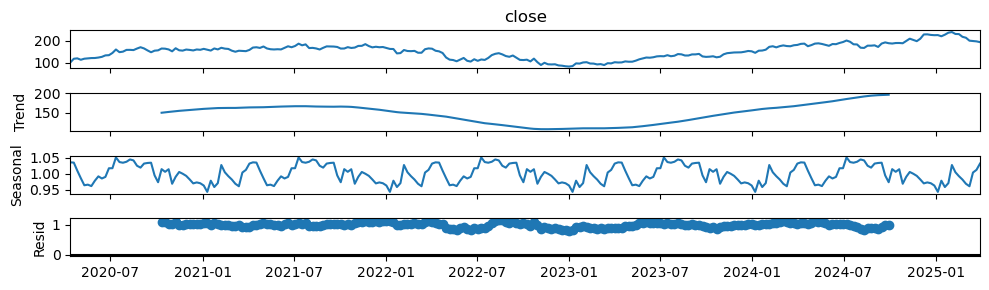

In [ ]:
# seasonal decompose
#First chart is the original time series, second chart is the trend, third chart is the seasonal component, and fourth chart is the residuals
#The seasonal component shows the repeating patterns in the data, such as the increase in stock price during the holiday season
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (10, 3)
AmZN_decomposed = seasonal_decompose(AMZN_Close_DF['close'], model='multiplicative')
AmZN_decomposed.plot()
plt.show()

In [ ]:
# stationarity test
#this 
from scipy.stats import shapiro, normaltest, kstest
from statsmodels.stats.diagnostic import kstest_normal

def is_normal(test, p_level = 0.05):
    stat, p_val = test
    return 'Normal' if p_val > 0.05 else 'Not Normal'

normal_args = (np.mean(AMZN_Close_DF['close']), np.std(AMZN_Close_DF['close']))
print(is_normal(shapiro(AMZN_Close_DF['close'])))
print(is_normal(normaltest(AMZN_Close_DF['close'])))
print(is_normal(kstest(AMZN_Close_DF['close'], 'norm', normal_args)))
print(is_normal(kstest_normal(AMZN_Close_DF['close'])))

Not Normal
Normal
Normal
Not Normal


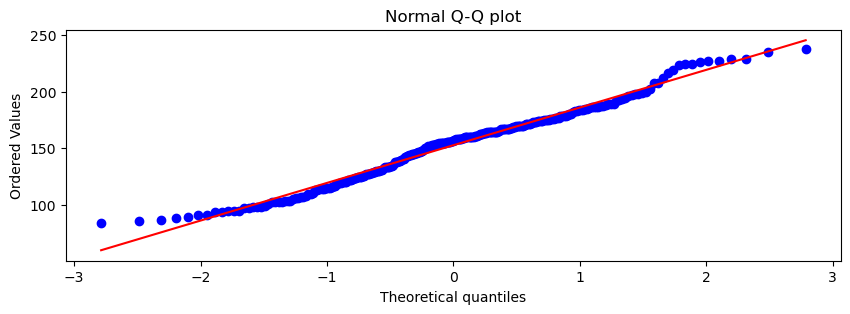

In [ ]:
# QQ Plot
# The Q-Q plot is a graphical tool to help assess if a dataset follows a normal distribution.
# It compares the quantiles of the dataset against the quantiles of a normal distribution.
stats.probplot(AMZN_Close_DF['close'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [40]:
from statsmodels.tsa.api import AutoReg
model = AutoReg(AMZN_Close_DF['close'], lags=1).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                  260
Model:                     AutoReg(1)   Log Likelihood                -849.296
Method:               Conditional MLE   S.D. of innovations              6.425
Date:                Sun, 06 Apr 2025   AIC                           1704.591
Time:                        06:44:00   BIC                           1715.262
Sample:                    04-19-2020   HQIC                          1708.881
                         - 03-30-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4800      1.873      1.858      0.063      -0.191       7.151
close.L1       0.9795      0.012     81.638      0.000       0.956       1.003
                                    Roots           

In [12]:
from statsmodels.stats.api import het_breuschpagan, het_white
import statsmodels.api as sm

def het_test(model, test=het_breuschpagan):
    lm, pval, __Fval, f_pval = test(model.resid, sm.add_constant(model.fittedvalues))
    return "heteroskedastic" if pval < 0.05 else "homoskedastic"

print(het_test(model, test=het_breuschpagan))
print(het_test(model, test=het_white))

homoskedastic
homoskedastic


In [13]:
from statsmodels.tsa.api import kpss, adfuller, STL
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tools.eval_measures import rmse, rmspe
from statsmodels.tsa.stattools import acf, pacf
import warnings
#warnings.filterwarnings('ignore')

In [14]:
# split data into train and test
train_size = int(len(AMZN_Close_DF) * 0.8)
train, test = AMZN_Close_DF[:train_size], AMZN_Close_DF[train_size:]  # 80% train, 20% test
train.shape, test.shape

((208, 1), (52, 1))

In [39]:
#this defines a function that find's the best SARIMA model Using AIC and BIC scores

def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k, v in score.items():
        if v[c] < initial_score:
            best_model = k
            initial_score = v[c]
            print(f'Best Model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [ ]:
#This function is used to plot the Sarima Model comparing the train and test data to the forecasted data
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style='-.')
    ax.legend(['train', 'test', 'forecast'])
    plt.show()

In [17]:
from itertools import product
   
def combinator(items):
       combo = [i for i in product(*items)]
       return combo

In [ ]:
import gc
import warnings
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Function to filter warnings related to SARIMAX
def warn_filter(record):
    return "SARIMAX" in str(record)  # Adjust this condition if needed

warnings.simplefilter("error")  # Convert warnings into errors

# Define parameter grids
P_ns, D_ns, Q_ns = [list(range(3))] * 3
P_s, D_s, Q_s = [list(range(2))] * 3
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
# this run a for loop that try's all the combinations of the parameters and stores the results in a dictionary
# The loop also prints the progress of the model fitting process
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i % 15 == 0:
        print(f'Running model #{i} using SARIMA ({p},{d},{q})x({P},{D},{Q})52')

    try:
        model = SARIMAX(train['close'], order=(p, d, q), seasonal_order=(P, D, Q, 52), enforce_stationarity=False)
        res = model.fit(disp=0)

        y = test.values.ravel()
        y_hat = res.forecast(steps=len(y))

        score[i] = {
            'non-seasonal order': (p, d, q),
            'seasonal order': (P, D, Q),
            'AIC': res.aic,
            'AICC': res.aicc,
            'BIC': res.bic,
            'RMSPE': rmspe(y, y_hat),
            'RMSE': rmse(y, y_hat),
            'MAPE': mape(y, y_hat),
            'model': res
        }
    
    except Warning as w:  # Skip models that produce warnings
        if warn_filter(w):
            print(f"Skipping model ({p},{d},{q})x({P},{D},{Q}) due to warning: {w}")
        continue

    # Free memory 
    del res
    gc.collect()

Running model #0 using SARIMA (0,0,0)x(0,0,0)52
Running model #15 using SARIMA (0,0,1)x(1,1,1)52
Running model #30 using SARIMA (0,1,0)x(1,1,0)52
Running model #45 using SARIMA (0,1,2)x(1,0,1)52
Running model #60 using SARIMA (0,2,1)x(1,0,0)52
Running model #75 using SARIMA (1,0,0)x(0,1,1)52
Running model #90 using SARIMA (1,0,2)x(0,1,0)52
Running model #105 using SARIMA (1,1,1)x(0,0,1)52
Running model #120 using SARIMA (1,2,0)x(0,0,0)52
Running model #135 using SARIMA (1,2,1)x(1,1,1)52
Running model #150 using SARIMA (2,0,0)x(1,1,0)52
Running model #165 using SARIMA (2,0,2)x(1,0,1)52
Running model #180 using SARIMA (2,1,1)x(1,0,0)52
Running model #195 using SARIMA (2,2,0)x(0,1,1)52
Running model #210 using SARIMA (2,2,2)x(0,1,0)52


In [ ]:
#this find's the best model using the AIC score and returns the model
best_model = get_best_model(score, c='AIC', )
print(best_model.summary())

Best Model: 2 with lowest AIC score: 1622.5938345776776
Best Model: 6 with lowest AIC score: 1073.148652962487
Best Model: 22 with lowest AIC score: 883.7701266698298
Best Model: 30 with lowest AIC score: 718.222614813581
Best Model: 62 with lowest AIC score: 715.6368739586161
Best Model: 102 with lowest AIC score: 711.4273181518599
Best Model: 118 with lowest AIC score: 708.4151830436438
Best Model: 142 with lowest AIC score: 707.2319482251743
Best Model: 174 with lowest AIC score: 706.2088456321535
Best Model: 190 with lowest AIC score: 701.984376031949
Best Model: 214 with lowest AIC score: 699.230635636098
                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                  208
Model:             SARIMAX(2, 2, 2)x(1, 1, [], 52)   Log Likelihood                -343.615
Date:                             Sat, 05 Apr 2025   AIC                            699.231
Time:         

                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                  208
Model:             SARIMAX(2, 2, 2)x(1, 1, [], 52)   Log Likelihood                -343.615
Date:                             Sat, 05 Apr 2025   AIC                            699.231
Time:                                     16:15:04   BIC                            714.862
Sample:                                 04-12-2020   HQIC                           705.557
                                      - 03-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9451      0.112     -8.453      0.000      -1.164      -0.726
ar.L2         -0.1754      

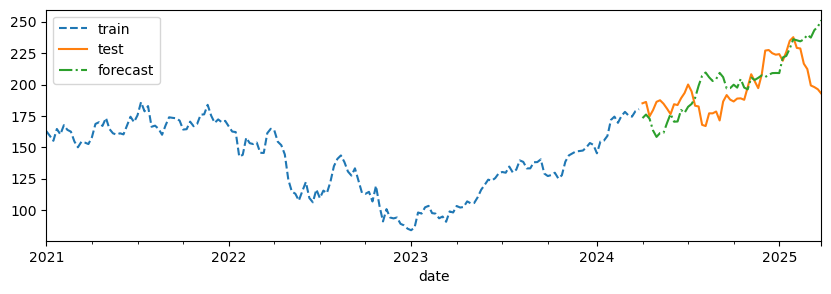

In [ ]:
# Plot the forecast for the best model
#this plots the forecast for the best model using the train and test data based on AIC score
plot_forecast(best_model,'2021' , train, test)

In [ ]:
#Takes crieteria scores and puts them into a DataFrame for better readability
#This is done to make it easier to compare the models and find the best one
#This is done by normalizing the scores and then summing them up to get a final score
df_score = pd.DataFrame.from_dict(score, orient='index')
df_score = df_score.drop(columns=['model'])
for col in ['AIC', 'BIC', 'RMSE']:
    df_score[col] = (df_score[col] - df_score[col].min()) / (df_score[col].max ()- df_score[col].min())
df_score['final_score'] = df_score[['AIC', 'BIC', 'RMSE']].sum(axis=1)
df_score.head(10)

,non-seasonal order,seasonal order,AIC,AICC,BIC,RMSPE,RMSE,MAPE,final_score
0,"(0, 0, 0)","(0, 0, 0)",1.000000,2647.578106,1.000000,10.000000,1.000000,1.000000,3.000000
2,"(0, 0, 0)","(0, 1, 0)",0.473926,1622.619978,0.470435,3.019481,0.245753,0.289692,1.190113
4,"(0, 0, 0)","(1, 0, 0)",0.476820,1628.310803,0.474926,3.483844,0.296065,0.339260,1.247811
6,"(0, 0, 0)","(1, 1, 0)",0.191917,1073.267465,0.187795,3.987726,0.367739,0.386502,0.747451
8,"(0, 0, 1)","(0, 0, 0)",0.853114,2361.436034,0.853898,9.927400,0.993144,0.990340,2.700155
12,"(0, 0, 1)","(1, 0, 0)",0.383053,1445.701461,0.382139,3.484124,0.296632,0.340006,1.061824
16,"(0, 0, 2)","(0, 0, 0)",0.734218,2129.848224,0.735958,9.870581,0.987737,0.981748,2.457914
18,"(0, 0, 2)","(0, 1, 0)",0.323610,1329.890611,0.322288,2.954499,0.239592,0.284045,0.885491
20,"(0, 0, 2)","(1, 0, 0)",0.367182,1414.886961,0.367742,3.710016,0.321266,0.363824,1.056191
22,"(0, 0, 2)","(1, 1, 0)",0.094717,884.174167,0.092708,3.892844,0.356665,0.376723,0.544091


In [48]:
best_model_index = df_score.loc[df_score['final_score'].idxmin()]  # Example using AIC
#best_params = score[best_model_index]
print(best_model_index)
print(f"Best Model: SARIMA {best_model_index['non-seasonal order']}x{best_model_index['seasonal order']}52")

non-seasonal order     (2, 2, 2)
seasonal order         (1, 1, 0)
AIC                          0.0
AICC                  700.133861
BIC                          0.0
RMSPE                   1.149946
RMSE                      0.0385
MAPE                    0.088265
final_score               0.0385
Name: 214, dtype: object
Best Model: SARIMA (2, 2, 2)x(1, 1, 0)52


In [51]:
best_p, best_d, best_q = best_model_index['non-seasonal order']
best_P, best_D, best_Q = best_model_index['seasonal order']

# Fit the final model on the entire dataset
final_model = SARIMAX(AMZN_Close_DF['close'], 
                      order=(best_p, best_d, best_q), 
                      seasonal_order=(best_P, best_D, best_Q, 52), 
                      enforce_stationarity=False)
final_res = final_model.fit()

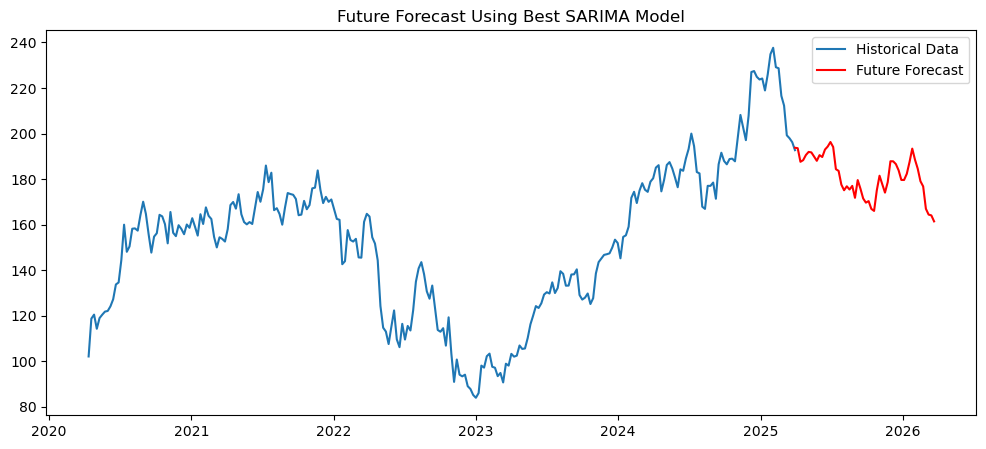

In [50]:
forecast_steps = 52  # Example: Forecasting one year ahead
future_forecast = final_res.forecast(steps=forecast_steps)

# Plot results
plt.figure(figsize=(12,5))
plt.plot(AMZN_Close_DF.index, AMZN_Close_DF['close'], label='Historical Data')
plt.plot(pd.date_range(AMZN_Close_DF.index[-1], periods=forecast_steps, freq='W'), future_forecast, label='Future Forecast', color='red')
plt.legend()
plt.title("Future Forecast Using Best SARIMA Model")
plt.show()